## 0.a. Importing OpenCV and Numpy
Code available here is based on OpenCV documentation and various websites:
 - GrabCut: https://docs.opencv.org/trunk/d8/d83/tutorial_py_grabcut.html
 - Color Spaces in OpenCV: https://www.learnopencv.com/color-spaces-in-opencv-cpp-python/
 - Color Spaces in OpenCV (Documentation): http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_colorspaces/py_colorspaces.html
 
**Future work**: Implement [this](https://github.com/underdoeg/ofxGreenscreen/blob/master/src/ofxGreenscreen.cpp) algorithm


In [35]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from timeit import default_timer as timer

## 0.b. Importing assets

In [36]:
img = cv2.cvtColor(cv2.imread("doggo.jpg"), cv2.COLOR_BGR2RGB)
img_mask = cv2.imread("doggo_mask.jpg")

# converts mask to gray8
img_mask = cv2.cvtColor(img_mask, cv2.COLOR_BGR2GRAY)

## 1. First try - Using GrabCut 

### Defining crop rect and mask 

In [37]:
# creates a binary mask where 0 is surely background and 1 is surely foreground
mask = np.zeros(img.shape[:2], 'uint8')
mask[img_mask > 15] = 2  # makes sure that places marked with gray (or closer) are tagged as probably background
mask[img_mask >= 240] = 1  # makes sure that places marked with white (or closer) are tagged as foreground

mask.shape

(1195, 2124)

### Showing mask

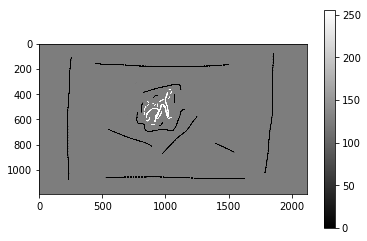

(<matplotlib.image.AxesImage at 0x7f6b96751cc0>,
 None)

In [38]:
plt.imshow(img_mask, cmap='gray'), plt.colorbar(), plt.show()

Showing what mask means

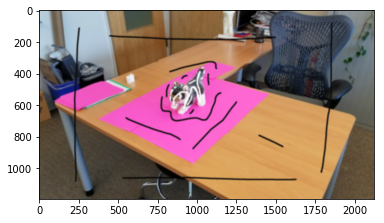

(<matplotlib.image.AxesImage at 0x7f6b96727320>, None)

In [39]:
img_mask_explanation = cv2.cvtColor(cv2.imread("doggo_mask_explanation.jpg"), cv2.COLOR_BGR2RGB)
plt.imshow(img_mask_explanation, interpolation = 'bicubic'), plt.show()

### Applying filter

In [40]:
# creating the two arrays that the algorithm uses internally
bgdModel = np.zeros((1, 65), np.float64)
fgdModel = np.zeros((1, 65), np.float64)

# applying algorithm. Arguments are the following:
# img - input image
# mask - mask image where we specify background (0 or cv2.GC_BGD), foreground (1), probable background(2), probable foreground(3)
# rect - selects region of interest (area that has the foreground). Format (x, y, w, h). Needs flag cv2.GC_INIT_WITH_RECT
# bdgModel, fdgModel - internally used
# iterCount - number of iterations the algorithm should run (5 in this case)
# mode - cv2.GC_INIT_WITH_RECT or cv2.GC_INIT_WITH_MASK or both combined. We are starting with a mask (and no rect); thus cv2.GC_INIT_WITH_MASK
ts = timer()
mask, bgdModel, fgdModel = cv2.grabCut(img, mask, None, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_MASK)
mask = np.where((mask==2)|(mask==0),0,1).astype('uint8')
newImg = img*mask[:, :, np.newaxis]
te = timer()
print("Operation took: %f seconds" % (te - ts))

Operation took: 28.022739 seconds


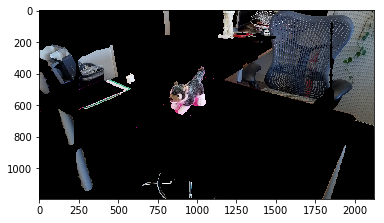

(<matplotlib.image.AxesImage at 0x7f6b966dc390>, None)

In [41]:
plt.imshow(newImg),plt.show()

For some reason, this did not yield the expected results and took me a couple of iterations. Moving on to a more streamlined (and simpler) algorithm

## Second try: Using a basic pixel filtering 

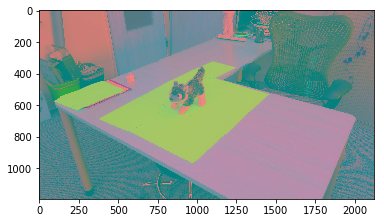

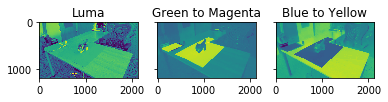

In [100]:
# Convert image from the BGR colorspace to the LAB colorspace
# Using the hint from this: https://www.learnopencv.com/color-spaces-in-opencv-cpp-python/
img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
img_lab_l = img_lab[:, :, 0]
img_lab_a = img_lab[:, :, 1]
img_lab_b = img_lab[:, :, 2]
plt.close('all')
plt.imshow(img_lab), plt.show()

# showing individual components
plt.close('all')
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
ax1.imshow(img_lab_l)
ax1.set_title('Luma')
ax2.imshow(img_lab_a)
ax2.set_title('Green to Magenta')
ax3.imshow(img_lab_b)
ax3.set_title('Blue to Yellow')
plt.show()
plt.close('all')



[[[168 195 102]]]
Using color [168 198 101]


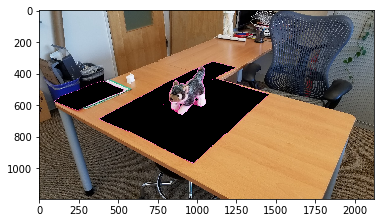

(<matplotlib.image.AxesImage at 0x7f6b914b2208>, None)

In [142]:
# convert pink color to LAB
pink_color_rgb = np.zeros((1,1,3), 'uint8')
pink_color_rgb[0][0][0] = 252; pink_color_rgb[0][0][1] = 104; pink_color_rgb[0][0][2] = 208
pink_color_lab = cv2.cvtColor(pink_color_rgb, cv2.COLOR_RGB2LAB) # gives array([[[168 195 102]]], dtype=uint8)
print(pink_color_lab)
print("Using color",img_lab[840, 969])

# Basic pixel filtering (values choosen based on color above)
filter_color_lower = np.array([40, 190, 80])
filter_color_upper = np.array([250, 210, 117]) 
# notice above the range for Luminosity and Magenta!

# mask out
mask = cv2.inRange(img_lab, filter_color_lower, filter_color_upper)
res  = cv2.bitwise_and(img, img, mask= ~mask)

plt.imshow(res), plt.show()

### Time to try the same settings on a different picture

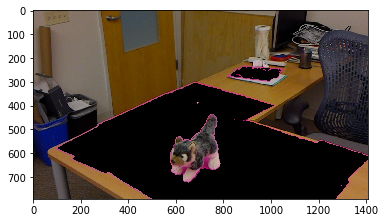

True

In [145]:
img2 = cv2.cvtColor(cv2.imread("doggo2.jpg"), cv2.COLOR_BGR2RGB)
img2_lab = cv2.cvtColor(img2, cv2.COLOR_RGB2LAB)
mask = cv2.inRange(img2_lab, filter_color_lower, filter_color_upper)
res  = cv2.bitwise_and(img2, img2, mask= ~mask)

plt.imshow(res), plt.show()
cv2.imwrite("doggo2_after.jpg", img2)